In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import svm, preprocessing
from sklearn.cluster import KMeans

from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Plot the raw training data

Sample size 394


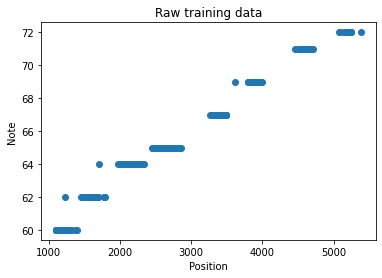

In [3]:
samples, labels = np.loadtxt('training_data.csv', delimiter=',', dtype=int)
notes = [60,62,64,65,67,69,71,72]

print("Sample size", len(samples))
plt.scatter(samples, labels)
plt.title('Raw training data')
plt.xlabel('Position')
plt.ylabel('Note')
plt.show()

# Remove bad training sample by K-Means

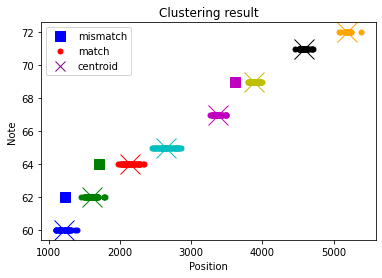

removed note 62 position 1234 from training data set
removed note 64 position 1700 from training data set
removed note 69 position 3621 from training data set


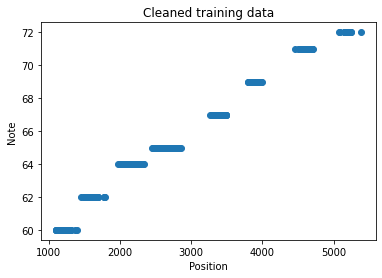

Sample size 391


In [8]:
km = KMeans(n_clusters=8)
km.fit(samples.reshape(-1,1))
centroids = sorted(km.cluster_centers_)
centroid_labels = list(km.predict(centroids))
colors = ["b","g","r","c","m","y","k","orange"]

prediction = km.predict(samples.reshape(-1,1))
mispredicted = []
for i in range(len(samples)):
    predicted_note_index = centroid_labels.index(prediction[i])
    predicted_note = notes[predicted_note_index]
    actual = labels[i]
    if predicted_note != actual:
        plt.plot(samples[i], actual, colors[predicted_note_index], marker='s', markersize = 10)
        mispredicted += [i]
    else:
        plt.plot(samples[i], actual, colors[predicted_note_index], marker='.', markersize = 10)

for i in range(len(centroids)):
    plt.plot(centroids[i], notes[i], colors[i], marker='x', markersize = 20)


plt.title('Clustering result')
plt.xlabel('Position')
plt.ylabel('Note')

h1 = mlines.Line2D([], [], color='blue', marker='s', linestyle='None',
                        markersize=10, label='mismatch')
h2 = mlines.Line2D([], [], color='red', marker='.', linestyle='None',
                        markersize=10, label='match')
h3 = mlines.Line2D([], [], color='purple', marker='x', linestyle='None',
                        markersize=10, label='centroid')
plt.legend(handles=[h1,h2,h3])
plt.show()

samples = list(samples)
labels = list(labels)
for m in mispredicted[::-1]:
    p = samples.pop(m)
    l = labels.pop(m)
    print(f'removed note {l} position {p} from training data set')
samples = np.array(samples)
labels = np.array(labels)


plt.scatter(samples, labels)
plt.title('Cleaned training data')
plt.xlabel('Position')
plt.ylabel('Note')
plt.show()
print("Sample size:", len(samples))


# Proprocessing

In [51]:
enc = preprocessing.LabelEncoder()
enc.fit(labels)
encoded_labels = enc.transform(labels)
train_samples, test_samples, train_labels, test_labels = train_test_split(samples,encoded_labels, test_size=0.02, random_state=20)
train_labels,train_samples=shuffle(train_labels,train_samples)
test_labels,test_samples=shuffle(test_labels,test_samples)


# Predict with NN

In [52]:
#Model
model=Sequential([Dense(units=64,input_shape=(1,),activation='relu'),
                 Dense(units=32,activation='relu'),
                 Dense (units=8,activation='softmax')])

#Training
model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x=train_samples,y=train_labels,epochs=3000,validation_data=(test_samples, test_labels),verbose=1)
model.summary()

Epoch 1/3000
12/12 [==============================] - 0s 13ms/step - loss: 677.2309 - accuracy: 0.1227 - val_loss: 497.2726 - val_accuracy: 0.1250
Epoch 2/3000
12/12 [==============================] - 0s 3ms/step - loss: 292.9144 - accuracy: 0.1044 - val_loss: 217.8513 - val_accuracy: 0.2500
Epoch 3/3000
12/12 [==============================] - 0s 3ms/step - loss: 166.4932 - accuracy: 0.1384 - val_loss: 156.3511 - val_accuracy: 0.1250
Epoch 4/3000
12/12 [==============================] - 0s 3ms/step - loss: 104.8826 - accuracy: 0.1488 - val_loss: 92.3303 - val_accuracy: 0.0000e+00
Epoch 5/3000
12/12 [==============================] - 0s 3ms/step - loss: 56.2815 - accuracy: 0.1279 - val_loss: 38.1905 - val_accuracy: 0.0000e+00
Epoch 6/3000
12/12 [==============================] - 0s 3ms/step - loss: 26.7714 - accuracy: 0.1070 - val_loss: 12.1145 - val_accuracy: 0.0000e+00
Epoch 7/3000
12/12 [==============================] - 0s 3ms/step - loss: 18.8715 - accuracy: 0.1279 - val_loss: 28.

# Plot Results

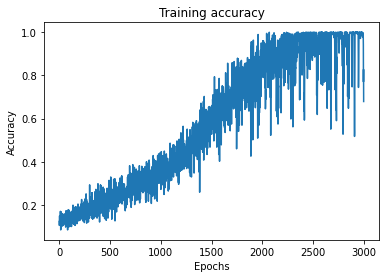

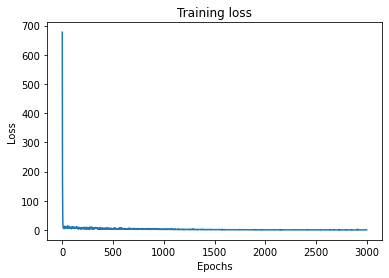

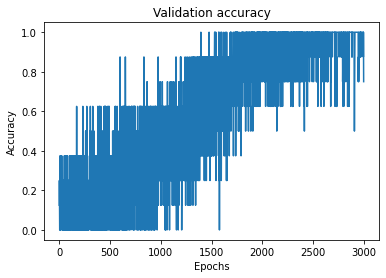

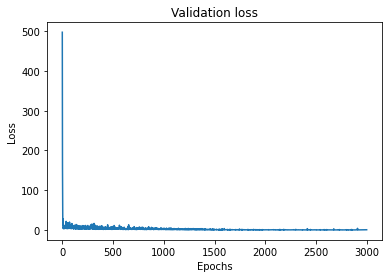

In [60]:
#Plot graph
plt.plot(history.history['accuracy'])
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


plt.plot(history.history['val_loss'])
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Classify by SVM

In [58]:
from sklearn import svm
svc = svm.SVC()
svc.fit(train_samples.reshape(-1,1), train_labels)


SVC()

# Visualize Classifier

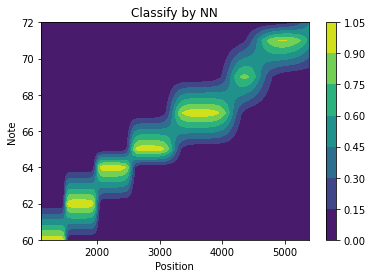

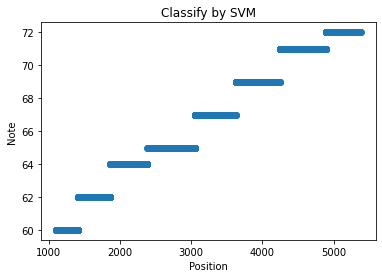

In [63]:
step=1
xs = np.arange(samples.min(), samples.max(), step)
output = model.predict(xs)
c = plt.contourf(xs, notes , output.T)
plt.colorbar(c)
plt.title('Classify by NN')
plt.xlabel('Position')
plt.ylabel('Note')
plt.show()

output = svc.predict(xs.reshape(-1,1))
output = enc.inverse_transform(output)
plt.scatter(xs, output)
plt.title('Classify by SVM')
plt.xlabel('Position')
plt.ylabel('Note')
plt.show()

# Save the training model

In [64]:
#Save model
model.save("trained_model.h5")
#Load .h5 model and predict
model = load_model('trained_model.h5')